# Score-based Generative Modeling with implicit potential score matching

In [20]:
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim
import torch.nn as nn
import lib.toy_data as toy_data
import numpy as np
import argparse

import deepxde as dde
from deepxde.backend import pytorch

### Parsing for scripts

In [21]:
parser = argparse.ArgumentParser('simple_sgm_experiments')
parser.add_argument('--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings'], type = str,default = 'moons')
parser.add_argument('--depth',help = 'number of hidden layers of score network',type =int, default = 7)
parser.add_argument('--hiddenunits',help = 'number of nodes per hidden layer', type = int, default = 32)
parser.add_argument('--niters',type = int, default = 100000)
parser.add_argument('--batch_size', type = int,default = 64)
parser.add_argument('--lr',type = float, default = 1e-3) 
parser.add_argument('--finalT',type = float, default = 5)
parser.add_argument('--dt',type = float,help = 'integrator step size', default = 0.001)
parser.add_argument('--save',type = str,default = 'experiments/simple_sgm/')

_StoreAction(option_strings=['--save'], dest='save', nargs=None, const=None, default='experiments/simple_sgm/', type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

### Change parameters here (comment out below for default options)

In [22]:
# Basic parameters
args = parser.parse_args('')

learning_rate = args.lr # learning rate for training neural network
batch_size = args.batch_size # batch size during training of neural network
epochs = args.niters # Number of training epochs for the neural network
T = args.finalT   # Forward simulation time in the forward SDE
dataset = args.data # Dataset choice, see toy_data for full options of toy datasets ('checkerboard','8gaussians','2spirals','swissroll','moons',etc.)
depth = args.depth
hidden_units = args.hiddenunits
# args.dt = 0.001

### Score network functions

In [23]:
def construct_score_model(depth:int, hidden_units:int):
    '''
    Initializes neural network that models the score function
    '''
    chain = []
    chain.append(nn.Linear(3,int(hidden_units),bias =True)) # hard coded input side: (t, x) ∊ R x R^2
    chain.append(nn.GELU())

    for _ in range(depth-1):
        chain.append(nn.Linear(int(hidden_units),int(hidden_units),bias = True))
        chain.append(nn.GELU())
    chain.append(nn.Linear(int(hidden_units),2,bias = True)) # hard coded output size: x ∊ R^2

    return nn.Sequential(*chain)

### Score matching functions

In [24]:
def noise_samples(t:torch.Tensor, samples:torch.Tensor):
    '''
    Noises each entry of `samples` tensor forward by the corresponding entry in the time tensor `t`
    '''
    sigmas = torch.sqrt(1 - torch.exp(-t))
    # makes a column vec of length (# samples). * arg is to make sure the dimensions dim(samples)
    sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
    # Generate noise ξ for each coordinate of each sample, and multiply by sigma
    noise = torch.randn_like(samples) * sigmas
    # repeat each element time vector so that it can be added to each coordinate in a sample
    # transpose to match dimension of system of samples
    t_enlarge = t.repeat(2,1).T
    # Finally add the noise to each data point, computing x_i^{t_i} 
    perturbed_samples = torch.tensor(samples * torch.exp(-0.5 * t_enlarge) + noise,requires_grad=True) 

    return perturbed_samples

def time_ism_score_estimator(scorenet:nn.Sequential,samples:torch.Tensor,Tmin:int,Tmax:int,eps:int):
    '''
    Given learned score function `scorenet` and samples `samples`, returns value of ISM objective function function.
    '''
    t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin # sample uniformly from time interval

    perturbed_samples = noise_samples(t, samples) # add noise to samples

    # Evaluate the score function
    score_eval_samples = torch.cat((t.reshape(-1,1),perturbed_samples),1)
    scores = scorenet(score_eval_samples)

    # Evaluate the divergence
    s1x = dde.gradients.jacobian(scores,score_eval_samples,i = 0,j = 1)
    s2y = dde.gradients.jacobian(scores,score_eval_samples,i = 1,j = 2)

    s1x = s1x.view(s1x.shape[0],-1)
    s1x = s1x.sum(dim=-1)

    s2y = s2y.view(s2y.shape[0],-1)
    s2y = s2y.sum(dim=-1)

    scores = scores.view(scores.shape[0],-1)

    # Evaluate object function
    loss = ((s1x+s2y) + 0.5*(scores**2).sum(dim = -1)) 

    return loss.mean(dim = 0)

### SDE Dynamics functions

In [25]:
def ou_dynamics(init, T):
    '''
    Solves the OU process exactly given deterministic initial condition `init` and final time `T`
    '''
    return init * torch.exp(- 0.5 * T) + torch.sqrt(1-torch.exp(-T)) * torch.randn_like(init)

def reverse_sde(score, init,T,lr=args.dt):
    '''
    Given learned score function `score`, reverses random datapoints `init`
    '''
    step = int(T/lr) 
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

def reverse_ode_flow(score,init,T,lr = args.dt):
    '''
    The deterministic ODE flow that can also sample from the target distribution
    '''
    step = int(T/lr)
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + 1/2 * score(evalpoint).detach())
    return init

### Simulation functions

In [26]:
def denoise(scorenet: nn.Sequential):
    '''
    Uses learned `scorenet` to generate new samples ~ π from Gaussian noise
    '''
    noise = torch.randn(10000, 2) 
    generated_samples = reverse_sde(scorenet, noise, torch.tensor(T)).detach().numpy()
    return generated_samples

def save_training_slice(samples, depth, hiddenunits, epoch, dataset):
    plt.clf()
    plt.scatter(samples[:,0],samples[:,1],s = 0.1)
    plt.axis('square')

    plt.savefig(f'images/training_slices/{dataset}/{depth}-{hiddenunits}-{epoch}.png')

### Main

moons with depth 7 and 32 hidden units per layer.
tensor(0.0148, grad_fn=<MeanBackward1>) 0 64


/var/folders/85/s_22yz957w980y3c4qrbd32w0000gn/T/ipykernel_47206/440506406.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_samples = torch.tensor(samples * torch.exp(-0.5 * t_enlarge) + noise,requires_grad=True)


tensor(-0.8871, grad_fn=<MeanBackward1>) 1000 64


KeyboardInterrupt: 

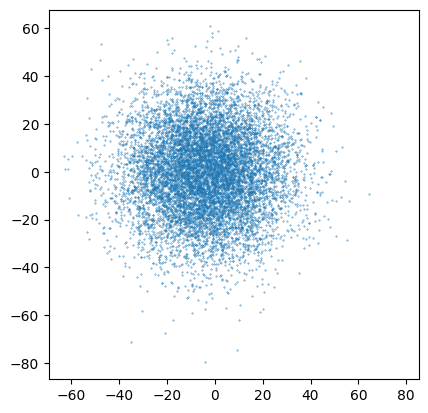

In [27]:
# Initialize score network
scorenet = construct_score_model(depth, hidden_units)
# print(scorenet)
print(f'{dataset} with depth {depth} and {hidden_units} hidden units per layer.')
optimizer = optim.Adam(scorenet.parameters(), lr=args.lr)

# Training the score network
p_samples = toy_data.inf_train_gen(dataset, batch_size = 1000000)
training_samples = torch.tensor(p_samples).to(dtype = torch.float32)

for step in range(epochs):
    # sample toy_data
    randind = torch.randint(0,1000000,[batch_size,])
    samples = training_samples[randind,:]

    # evaluate loss function and gradient
    # t = torch.linspace(0,T,100)
    loss = time_ism_score_estimator(scorenet,samples,0,T,eps = 0.001)
    optimizer.zero_grad()
    loss.backward()

    # Update score network
    optimizer.step()

    if not step % 1000:
        print(loss,step)
    
    if not step % 1000:
        samples = denoise(scorenet)
        save_training_slice(samples, depth, hidden_units, step, dataset)

# Denoising the normal distribution 
samples_lang = denoise(scorenet)

# # Denoising samples from the training data
# samples = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 10000))
# samples_lang_noisedtraining = samples * torch.exp(-0.5 * torch.tensor(T)) + torch.sqrt(1-torch.exp(-torch.tensor(T))) * torch.randn_like(samples)
# samples_lang_noisedtraining =reverse_sde(scorenet, samples_lang_noisedtraining.to(dtype=torch.float32),torch.tensor(T)).detach().numpy()

# # Deterministically evolving the normal distribution 
# samples_lang_deterministic = torch.randn(10000,2)
# samples_lang_deterministic = reverse_ode_flow(scorenet,samples_lang_deterministic,torch.tensor(T)).detach().numpy()

# Plot results

plt.clf()
plt.scatter(samples_lang[:,0],samples_lang[:,1],s = 0.1)
plt.axis('square')
# plt.axis([-5 ,5 ,-5, 5])

# Plot truth

plt.clf()
p_samples = toy_data.inf_train_gen(dataset, batch_size = 10000)
samples_true = torch.tensor(p_samples).to(dtype = torch.float32)
plt.scatter(samples_true[:,0],samples_true[:,1],s = 0.1)
plt.axis('square')
# plt.axis([-5 ,5 ,-5, 5])
plt.title('Truth')